In [1]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import os

In [2]:
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

# Day1_Create the  population & employment data in MSA region

## <font color='#F7DC6F '>Read Historical Delineation Files of the MSA regions</font>

In [3]:
# from shapely.geometry import box

# msa_shp = gpd.read_file('tl_2019_us_cbsa.zip')

# # filter out only the MSAs in the mainland US
# minx, miny, maxx, maxy = -124.763068, 24.523096, -66.949895, 49.384358
# bbox = box(minx, miny, maxx, maxy)
# bbox_gdf = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=msa_shp.crs)

# msa_shp = gpd.clip(msa_shp, bbox_gdf)
# msa_shp

In [4]:
msa_shp = gpd.read_file('tl_2019_us_cbsa.zip')
msa_shp

,CSAFP,CBSAFP,GEOID,NAME,NAMELSAD,LSAD,MEMI,MTFCC,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,122,12020,12020,"Athens-Clarke County, GA","Athens-Clarke County, GA Metro Area",M1,1,G3110,2654601832,26140309,+33.9439840,-083.2138965,"POLYGON ((-83.53739 33.96591, -83.53184 33.968..."
1,122,12060,12060,"Atlanta-Sandy Springs-Alpharetta, GA","Atlanta-Sandy Springs-Alpharetta, GA Metro Area",M1,1,G3110,22494938651,387716575,+33.6937280,-084.3999113,"POLYGON ((-85.33823 33.65312, -85.33842 33.654..."
2,428,12100,12100,"Atlantic City-Hammonton, NJ","Atlantic City-Hammonton, NJ Metro Area",M1,1,G3110,1438776649,301268696,+39.4693555,-074.6337591,"POLYGON ((-74.85675 39.42076, -74.85670 39.420..."
3,194,12220,12220,"Auburn-Opelika, AL","Auburn-Opelika, AL Metro Area",M1,1,G3110,1573514768,21526461,+32.6040644,-085.3530477,"POLYGON ((-85.29322 32.73073, -85.28826 32.730..."
4,NaN,12260,12260,"Augusta-Richmond County, GA-SC","Augusta-Richmond County, GA-SC Metro Area",M1,1,G3110,9015028913,262514053,+33.4603713,-081.9828327,"POLYGON ((-82.21865 33.68630, -82.21856 33.686..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,NaN,48660,48660,"Wichita Falls, TX","Wichita Falls, TX Metro Area",M1,1,G3110,6784838328,143920414,+33.7761441,-098.5019073,"POLYGON ((-98.95320 33.83402, -98.95320 33.838..."
388,558,48700,48700,"Williamsport, PA","Williamsport, PA Metro Area",M1,1,G3110,3182485518,39032440,+41.3438824,-077.0552624,"POLYGON ((-77.42693 41.27734, -77.42734 41.278..."
389,NaN,48900,48900,"Wilmington, NC","Wilmington, NC Metro Area",M1,1,G3110,2754572932,516647220,+34.4260331,-077.8896340,"POLYGON ((-78.02992 34.33177, -78.03074 34.331..."
390,548,49020,49020,"Winchester, VA-WV","Winchester, VA-WV Metro Area",M1,1,G3110,2752545068,16892497,+39.2729744,-078.4718276,"POLYGON ((-78.50813 39.08863, -78.50853 39.088..."


In [5]:
print('The count of MSAs:', msa_shp['NAMELSAD'].unique().size)
print('The count of CBSAs:', msa_shp['CBSAFP'].unique().size)

The count of MSAs: 392
The count of CBSAs: 392


<Axes: >

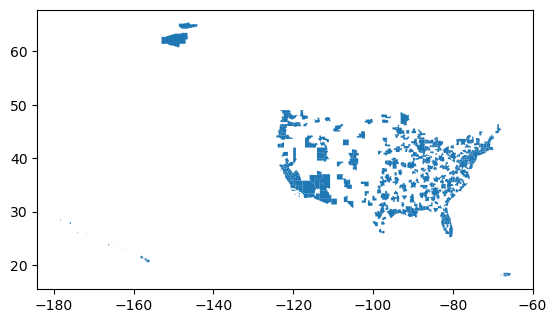

In [6]:
msa_shp.plot()

In [7]:
msa_us = pd.read_excel('list1_2020.xls',dtype={'FIPS State Code': 'object', 'FIPS County Code': 'object', 'CBSA Code':'object', 'CSA Code':'object'},header=2)
msa_us = msa_us[msa_us['Metropolitan/Micropolitan Statistical Area'] == 'Metropolitan Statistical Area'].reset_index(drop=True)
msa_us['fips_couty'] = msa_us['FIPS State Code'] + msa_us['FIPS County Code']
msa_us = msa_us[['CBSA Code','CBSA Title','Metropolitan/Micropolitan Statistical Area','County/County Equivalent','fips_couty','Central/Outlying County']]

In [8]:
msa_us

,CBSA Code,CBSA Title,Metropolitan/Micropolitan Statistical Area,County/County Equivalent,fips_couty,Central/Outlying County
0,10180,"Abilene, TX",Metropolitan Statistical Area,Callahan County,48059,Outlying
1,10180,"Abilene, TX",Metropolitan Statistical Area,Jones County,48253,Outlying
2,10180,"Abilene, TX",Metropolitan Statistical Area,Taylor County,48441,Central
3,10380,"Aguadilla-Isabela, PR",Metropolitan Statistical Area,Aguada Municipio,72003,Central
4,10380,"Aguadilla-Isabela, PR",Metropolitan Statistical Area,Aguadilla Municipio,72005,Central
...,...,...,...,...,...,...
1246,49660,"Youngstown-Warren-Boardman, OH-PA",Metropolitan Statistical Area,Trumbull County,39155,Central
1247,49660,"Youngstown-Warren-Boardman, OH-PA",Metropolitan Statistical Area,Mercer County,42085,Central
1248,49700,"Yuba City, CA",Metropolitan Statistical Area,Sutter County,06101,Central
1249,49700,"Yuba City, CA",Metropolitan Statistical Area,Yuba County,06115,Central


In [9]:
print('The count of CBSAs in msa_us file:', msa_us['CBSA Code'].unique().size)

import pandas as pd

# check whether all CBSAFP codes in msa are found in msa_us['CBSA Code']
result = msa_shp['CBSAFP'].isin(msa_us['CBSA Code'])

# cheeck which CBSAFP codes are not found in msa_us['CBSA Code']
not_found = msa_shp.loc[~result, 'CBSAFP']

# print the result
if not_found.empty:
    print("All CBSAFP codes in msa_shp are found in msa_us['CBSA Code'].")
else:
    print("The following CBSAFP codes are not found in msa_us['CBSA Code']:")
    print(not_found)

The count of CBSAs in msa_us file: 392
All CBSAFP codes in msa_shp are found in msa_us['CBSA Code'].


In [10]:
msa_us = msa_us.merge(msa_shp[['CBSAFP','NAMELSAD']], left_on='CBSA Code', right_on='CBSAFP', how='left')
msa_us

,CBSA Code,CBSA Title,Metropolitan/Micropolitan Statistical Area,County/County Equivalent,fips_couty,Central/Outlying County,CBSAFP,NAMELSAD
0,10180,"Abilene, TX",Metropolitan Statistical Area,Callahan County,48059,Outlying,10180,"Abilene, TX Metro Area"
1,10180,"Abilene, TX",Metropolitan Statistical Area,Jones County,48253,Outlying,10180,"Abilene, TX Metro Area"
2,10180,"Abilene, TX",Metropolitan Statistical Area,Taylor County,48441,Central,10180,"Abilene, TX Metro Area"
3,10380,"Aguadilla-Isabela, PR",Metropolitan Statistical Area,Aguada Municipio,72003,Central,10380,"Aguadilla-Isabela, PR Metro Area"
4,10380,"Aguadilla-Isabela, PR",Metropolitan Statistical Area,Aguadilla Municipio,72005,Central,10380,"Aguadilla-Isabela, PR Metro Area"
...,...,...,...,...,...,...,...,...
1246,49660,"Youngstown-Warren-Boardman, OH-PA",Metropolitan Statistical Area,Trumbull County,39155,Central,49660,"Youngstown-Warren-Boardman, OH-PA Metro Area"
1247,49660,"Youngstown-Warren-Boardman, OH-PA",Metropolitan Statistical Area,Mercer County,42085,Central,49660,"Youngstown-Warren-Boardman, OH-PA Metro Area"
1248,49700,"Yuba City, CA",Metropolitan Statistical Area,Sutter County,06101,Central,49700,"Yuba City, CA Metro Area"
1249,49700,"Yuba City, CA",Metropolitan Statistical Area,Yuba County,06115,Central,49700,"Yuba City, CA Metro Area"


## <font color='#F7DC6F '>Read Geometry Data at Tract Level in U.S Mainland regions</font>

In [11]:
# import pandas as pd
# import geopandas as gpd

# tracts_us = pd.DataFrame()

# exclude_states = ['02', '15', '72', '78', '60', '66', '69', '74', '75', '79', '81', '84', '86', '87', '89', '71']

# for i in range(80):
#     state = str(i).zfill(2)
#     if state in exclude_states:
#         continue
#     try:
#         url = 'https://www2.census.gov/geo/tiger/TIGER2020/TRACT/tl_2020_'+state+'_tract.zip'
#         tracts = gpd.read_file(url)
#         tracts_us = pd.concat([tracts_us, tracts])
#         print(f"Processed state: {state}")
#     except Exception as e:
#         print(f"Error processing state {state}: {e}")
#         continue

# tracts_us.plot()

<Axes: >

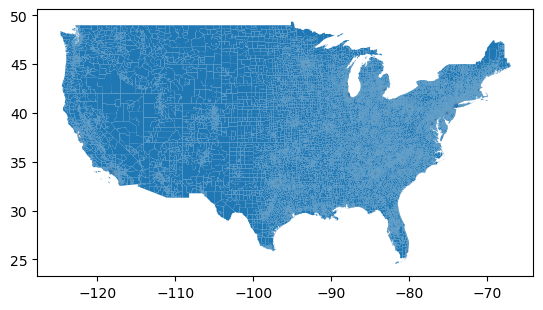

In [12]:
# read the API from the tiger line at Tract level
tracts_us = gpd.read_file('https://www2.census.gov/geo/tiger/GENZ2019/shp/cb_2019_us_tract_500k.zip')
# filter the outlines to only include the US states
exclude_states = ['02', '15', '72', '78', '60', '66', '69', '74', '75', '79', '81', '84', '86', '87', '89', '71']
tracts_us = tracts_us[~tracts_us['STATEFP'].isin(exclude_states)].reset_index(drop=True)
tracts_us['fips_couty'] = tracts_us['STATEFP'] + tracts_us['COUNTYFP']
tracts_us = tracts_us[['fips_couty','GEOID','ALAND','geometry']]

tracts_us.plot()

## <font color='#F7DC6F '>Merge MSA data into Tract Geometry Data</font>

In [13]:
msa_us_merge = msa_us.merge(tracts_us, on='fips_couty', how='left')
msa_us_merge = msa_us_merge.dropna()

msa_us_merge = gpd.GeoDataFrame(msa_us_merge, geometry='geometry',crs=tracts_us.crs)

In [14]:
msa_us_merge['NAMELSAD'].value_counts()

NAMELSAD
New York-Newark-Jersey City, NY-NJ-PA Metro Area           4534
Los Angeles-Long Beach-Anaheim, CA Metro Area              2926
Chicago-Naperville-Elgin, IL-IN-WI Metro Area              2210
Philadelphia-Camden-Wilmington, PA-NJ-DE-MD Metro Area     1476
Washington-Arlington-Alexandria, DC-VA-MD-WV Metro Area    1360
                                                           ... 
Grants Pass, OR Metro Area                                   16
Columbus, IN Metro Area                                      15
Carson City, NV Metro Area                                   14
Walla Walla, WA Metro Area                                   12
Enid, OK Metro Area                                          12
Name: count, Length: 380, dtype: int64

## <font color='#F7DC6F '>Read population and employment data by API </font>

In [15]:
# import json
# import pandas as pd
# from census import Census
# from us import states

# # Read Census API key
# with open("census_api_key_Houpu.json", 'r') as f:
#     key_file = f.read()
# my_api_key = json.loads(key_file)['key']

# def fetch_census_data(fields):
#     """
#     Fetches census data for the specified fields in 2020 for all counties and tracts across the U.S.

#     Parameters:
#     - api_key: str, Census API key.
#     - fields: list of str, the specific columns to retrieve.
#     """
    
#     c = Census(my_api_key)
#     df = pd.DataFrame()
    
#     for state in states.STATES:
#         state_fips = state.fips
#         data = c.acs5.state_county_tract(fields=fields,
#                                          state_fips=state_fips,
#                                          county_fips="*",  # fetch all the counties
#                                          tract="*",  # fetch all the tracts
#                                          year=2019)
        
#         state_df = pd.DataFrame(data)
#         df = pd.concat([df, state_df], ignore_index=True)
    
#     df['year'] = 2019
    
#     return df

In [16]:
# fields = ['NAME', 'B01003_001E']  # B01003_001E:total population
# pop_20 = fetch_census_data(fields)
# pop_20 = pop_20.rename(columns={'B01003_001E':'tot_pop'})
# pop_20['GEOID'] = pop_20['state'] + pop_20['county'] + pop_20['tract']

In [17]:
# fields = ['NAME', 'B23001_001E']  # B23001_001:total employment for the 16 years old and over
# emp_20 = fetch_census_data(fields)
# emp_20 = emp_20.rename(columns={'B23001_001E':'tot_emp'})
# emp_20['GEOID'] = emp_20['state'] + emp_20['county'] + emp_20['tract']

In [18]:
import requests
import pandas as pd

# Step 1: Fetch the data from the API
url = 'https://api.census.gov/data/2019/acs/acs5?get=group(B01003)&ucgid=pseudo(0100000US$1400000)'
response = requests.get(url)
data = response.json()

# Step 2: Convert the JSON response to a pandas DataFrame
columns = data[0]
rows = data[1:]
pop_19 = pd.DataFrame(rows, columns=columns)

In [19]:
pop_19 = pop_19.rename(columns={'B01003_001E':'tot_pop'})
pop_19['tot_pop'] = pop_19['tot_pop'].astype(int)
pop_19['GEOID'] = pop_19['GEO_ID'].str[9:]
pop_19 = pop_19[['GEOID','tot_pop']]

In [20]:
emp_19 = pd.read_csv('ACSDT5Y2019.B23025-Data.csv')
emp_19 = emp_19.iloc[1:,:]
emp_19 = emp_19.rename(columns={'B23025_004E':'tot_emp'})
emp_19['tot_emp'] = emp_19['tot_emp'].astype(int)
emp_19['GEOID'] = emp_19['GEO_ID'].str[9:]
emp_19 = emp_19[['GEOID','tot_emp']]

## <font color='#F7DC6F '>Integrate the data into MSA geomotry data</font>

In [21]:
msa_us_merge = msa_us_merge.merge(pop_19[['GEOID','tot_pop']], on='GEOID', how='left').merge(emp_19[['GEOID','tot_emp']], on='GEOID', how='left').dropna().reset_index(drop=True)

In [22]:
msa_us_merge.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 60543 entries, 0 to 60542
Data columns (total 13 columns):
 #   Column                                      Non-Null Count  Dtype   
---  ------                                      --------------  -----   
 0   CBSA Code                                   60543 non-null  object  
 1   CBSA Title                                  60543 non-null  object  
 2   Metropolitan/Micropolitan Statistical Area  60543 non-null  object  
 3   County/County Equivalent                    60543 non-null  object  
 4   fips_couty                                  60543 non-null  object  
 5   Central/Outlying County                     60543 non-null  object  
 6   CBSAFP                                      60543 non-null  object  
 7   NAMELSAD                                    60543 non-null  object  
 8   GEOID                                       60543 non-null  object  
 9   ALAND                                       60543 non-null  floa

In [23]:
msa_us_merge['NAMELSAD'].value_counts()

NAMELSAD
New York-Newark-Jersey City, NY-NJ-PA Metro Area           4534
Los Angeles-Long Beach-Anaheim, CA Metro Area              2926
Chicago-Naperville-Elgin, IL-IN-WI Metro Area              2210
Philadelphia-Camden-Wilmington, PA-NJ-DE-MD Metro Area     1476
Washington-Arlington-Alexandria, DC-VA-MD-WV Metro Area    1360
                                                           ... 
Grants Pass, OR Metro Area                                   16
Columbus, IN Metro Area                                      15
Carson City, NV Metro Area                                   14
Walla Walla, WA Metro Area                                   12
Enid, OK Metro Area                                          12
Name: count, Length: 380, dtype: int64

<Axes: >

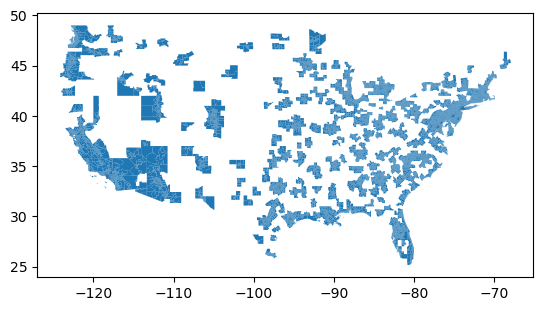

In [24]:
msa_us_merge.plot()

[MSA map published by United States Census Bureau](https://www.census.gov/geographies/reference-maps/2020/geo/cbsa.html)

# Day2&3_Delineate the Polymetric and Monometric analysis by LISA and GWR

## <font color='#F7DC6F '>Delineate the Main Center by Local Moran'I</font>

In [25]:
from pysal.viz import splot
from splot.esda import plot_moran
from pysal.explore import esda
from pysal.lib import weights
from esda.moran import Moran
from libpysal.weights import Queen, KNN
from numpy.random import seed

from splot import esda as esdaplot

In [26]:
msa_us_merge = msa_us_merge.to_crs(epsg=3857)

In [27]:
msa_us_merge['area'] = msa_us_merge['geometry'].area
msa_us_merge['tot_pop_density'] = (msa_us_merge['tot_pop'] / msa_us_merge['area']) * 1000000
msa_us_merge['tot_emp_density'] = (msa_us_merge['tot_emp'] / msa_us_merge['area']) * 1000000

In [28]:
msa_us_merge[['tot_pop_density','tot_emp_density']].describe()

,tot_pop_density,tot_emp_density
count,60543.00,60543.00
mean,1468.10,728.55
std,2838.23,1472.99
min,0.00,0.00
25%,204.99,92.92
50%,696.44,328.50
75%,1498.95,727.44
max,73317.10,39195.30


### LISA by Total Population

In [29]:
# create a new datafram to store the results of lisa
lisa_results_pop = pd.DataFrame()

for msa_id, msa_data in msa_us_merge.groupby('NAMELSAD'):

    w = KNN.from_dataframe(msa_data, k=8)
    w.transform = 'R'
    
    lisa = esda.moran.Moran_Local(msa_data["tot_pop_density"], w, permutations=9999)
    
    msa_data['LISA'] = lisa.Is
    msa_data['LISA_p'] = lisa.p_sim
    msa_data['LISA_q'] = lisa.q  # Quadrant information
    
    lisa_results_pop = pd.concat([lisa_results_pop, msa_data])
    
lisa_results_pop = gpd.GeoDataFrame(lisa_results_pop, geometry='geometry', crs="EPSG:3857")
lisa_results_pop['sig'] = (lisa_results_pop['LISA_p'] < 0.01) * 1

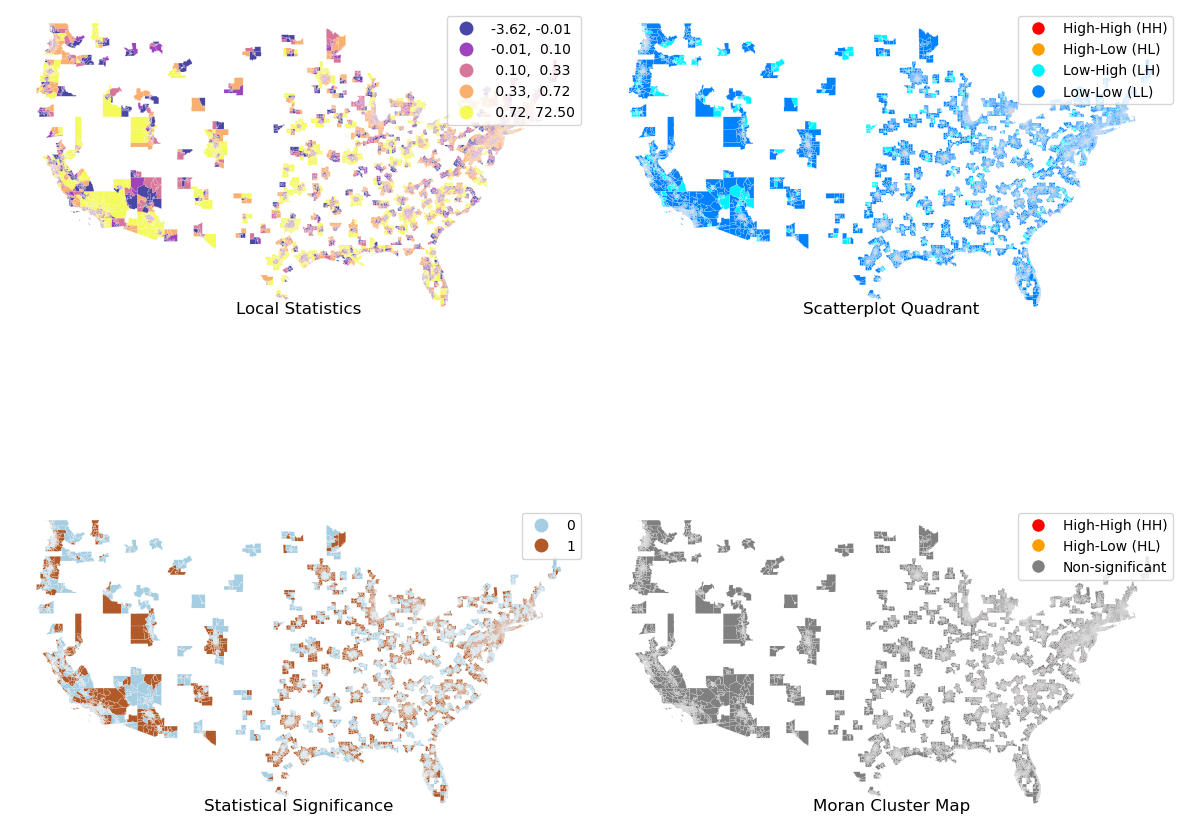

In [30]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
# Choropleth of local statistics
lisa_results_pop.plot(
    column="LISA",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=axs[0],
)

# Subplot 2 #
# Quadrant categories
quadrant_cmap = {
    1: '#FF0000',    # HH
    2: '#00F2FF',   # LH
    3: '#0082FF',  # LL
    4: '#FF9E00'  # HL
}

# Apply the colormap to the LISA_q column
lisa_results_pop['quadrant_color'] = lisa_results_pop['LISA_q'].map(quadrant_cmap)

# Create a custom legend
quadrant_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=quadrant_cmap[i], markersize=10, label=label)
                    for i, label in zip([1, 4, 2, 3], ['High-High (HH)', 'High-Low (HL)', 'Low-High (LH)','Low-Low (LL)'])]

lisa_results_pop.plot(
    color=lisa_results_pop['quadrant_color'],
    linewidth=0.1,
    edgecolor="white",
    legend=False,
    ax=axs[1],
)
axs[1].legend(handles=quadrant_handles)

# Subplot 3 #
# Significance map
lisa_results_pop.plot(
    column="sig",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=axs[2],
)

# Subplot 4 #
# Cluster map
cluster_colors = {0: 'grey', 1: '#FF0000', 4: '#FF9E00'}
lisa_results_pop['cluster_color'] = np.where(
    (lisa_results_pop['sig'] == 1) & (lisa_results_pop['LISA_q'].isin([1, 4])),
    lisa_results_pop['LISA_q'].map(cluster_colors),
    'grey'
)

# Create a custom legend for clusters
cluster_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cluster_colors[i], markersize=10, label=label)
                   for i, label in zip([1, 4, 0], ['High-High (HH)', 'High-Low (HL)', 'Non-significant'])]

lisa_results_pop.plot(
    color=lisa_results_pop['cluster_color'],
    linewidth=0.1,
    edgecolor="white",
    legend=False,
    ax=axs[3],
)
axs[3].legend(handles=cluster_handles)

# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=0,
    )
# Tight layout to minimise in-between white space
f.tight_layout()

# Display the figure
plt.show()

In [31]:
# lisa_results_pop.to_file('lisa_results_popden_0.01.shp')

### LISA by Total Employment

In [32]:
# create a new datafram to store the results of lisa
lisa_results_emp = pd.DataFrame()

for msa_id, msa_data in msa_us_merge.groupby('NAMELSAD'):

    w = KNN.from_dataframe(msa_data, k=8)
    w.transform = 'R'
    
    lisa = esda.moran.Moran_Local(msa_data["tot_emp_density"], w, permutations=9999)
    
    msa_data['LISA'] = lisa.Is
    msa_data['LISA_p'] = lisa.p_sim
    msa_data['LISA_q'] = lisa.q  # Quadrant information
    
    lisa_results_emp = pd.concat([lisa_results_emp, msa_data])
    
lisa_results_emp = gpd.GeoDataFrame(lisa_results_emp, geometry='geometry', crs="EPSG:3857")
lisa_results_emp['sig'] = (lisa_results_emp['LISA_p'] < 0.01) * 1

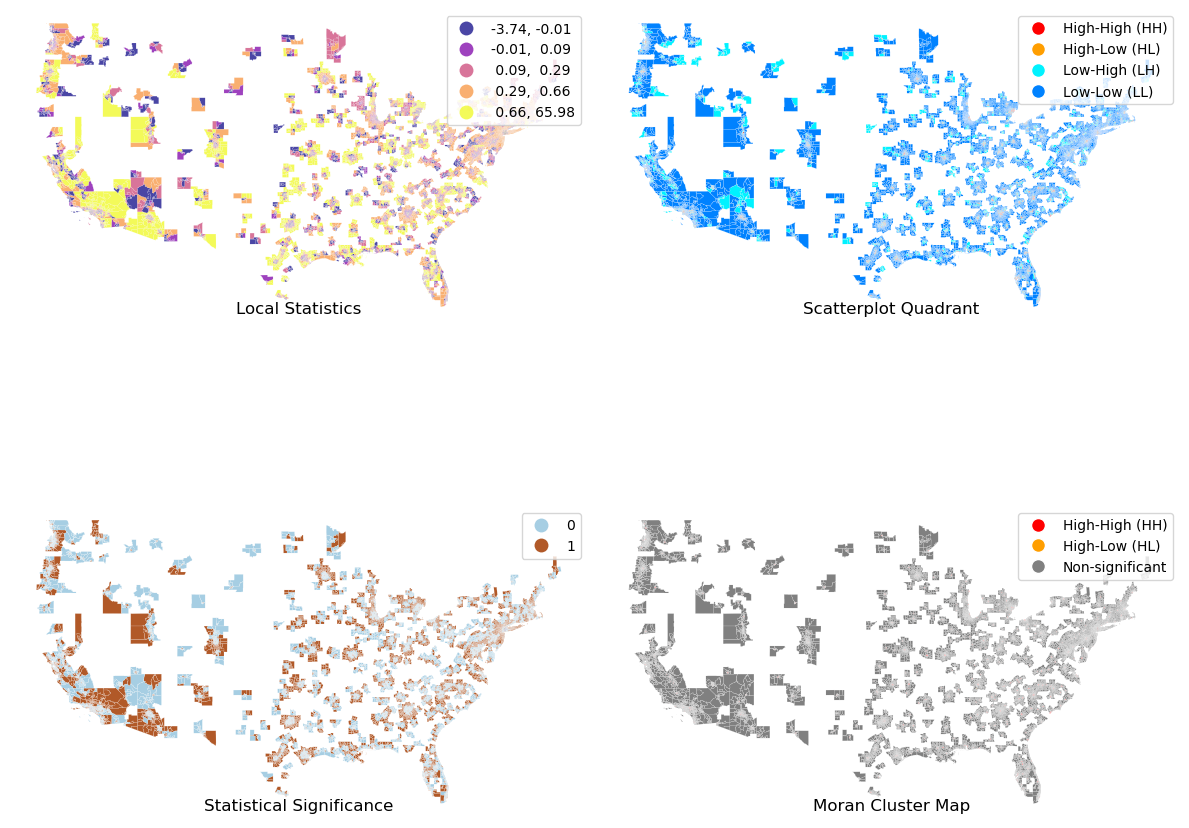

In [33]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
# Choropleth of local statistics
lisa_results_emp.plot(
    column="LISA",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=axs[0],
)

# Subplot 2 #
# Quadrant categories
quadrant_cmap = {
    1: '#FF0000',    # HH
    2: '#00F2FF',   # LH
    3: '#0082FF',  # LL
    4: '#FF9E00'  # HL
}

# Apply the colormap to the LISA_q column
lisa_results_emp['quadrant_color'] = lisa_results_emp['LISA_q'].map(quadrant_cmap)

# Create a custom legend
quadrant_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=quadrant_cmap[i], markersize=10, label=label)
                    for i, label in zip([1, 4, 2, 3], ['High-High (HH)', 'High-Low (HL)', 'Low-High (LH)','Low-Low (LL)'])]

lisa_results_emp.plot(
    color=lisa_results_emp['quadrant_color'],
    linewidth=0.1,
    edgecolor="white",
    legend=False,
    ax=axs[1],
)
axs[1].legend(handles=quadrant_handles)

# Subplot 3 #
# Significance map
lisa_results_emp.plot(
    column="sig",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=axs[2],
)

# Subplot 4 #
# Cluster map
cluster_colors = {0: 'grey', 1: '#FF0000', 4: '#FF9E00'}
lisa_results_emp['cluster_color'] = np.where(
    (lisa_results_emp['sig'] == 1) & (lisa_results_emp['LISA_q'].isin([1, 4])),
    lisa_results_emp['LISA_q'].map(cluster_colors),
    'grey'
)

# Create a custom legend for clusters
cluster_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cluster_colors[i], markersize=10, label=label)
                   for i, label in zip([1, 4, 0], ['High-High (HH)', 'High-Low (HL)', 'Non-significant'])]

lisa_results_emp.plot(
    color=lisa_results_emp['cluster_color'],
    linewidth=0.1,
    edgecolor="white",
    legend=False,
    ax=axs[3],
)
axs[3].legend(handles=cluster_handles)

# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=0,
    )
# Tight layout to minimise in-between white space
f.tight_layout()

# Display the figure
plt.show()

In [34]:
# lisa_results_emp.to_file('lisa_results_empden_0.01.shp')

# Day 3_Contiguity Analysis - HH (High-High) and HL (High-Low) Combination

In [35]:
# pick up HH and HL clusters tracts
polycentric = lisa_results_pop[((lisa_results_pop['LISA_q'] == 1) | (lisa_results_pop['LISA_q'] == 4)) & (lisa_results_pop['sig'] == 1)].reset_index(drop=True)

In [36]:
# dissolved_polycentric = polycentric.dissolve(by='NAMELSAD', aggfunc={'tot_pop': 'sum', 'tot_emp': 'sum'})
# dissolved_polycentric['area'] = dissolved_polycentric['geometry'].area
# dissolved_polycentric['tot_pop_density'] = (dissolved_polycentric['tot_pop'] / dissolved_polycentric['area']) * 1000000

In [37]:
# dissolved geometry in each MSA
dissolved_polycentric = polycentric.dissolve(by='NAMELSAD').reset_index()
dissolved_polycentric = dissolved_polycentric[['NAMELSAD','geometry']]

# explore the multipolygon into ploygon
exploded_polycentric = dissolved_polycentric.explode(column='geometry', ignore_index=True)

In [38]:
# calculate the total population in each combined polygon
spatial_joined_within = gpd.sjoin(polycentric, exploded_polycentric, how='inner', op='within')
total_pop_sum = spatial_joined_within.groupby('index_right')['tot_pop'].sum().reset_index()
exploded_polycentric = exploded_polycentric.merge(total_pop_sum, left_index=True, right_on='index_right', how='left').drop(columns='index_right')

In [39]:
exploded_polycentric['area'] = exploded_polycentric['geometry'].area
exploded_polycentric['tot_pop_density'] = (exploded_polycentric['tot_pop'] / exploded_polycentric['area']) * 1000000  # per square km

In [40]:
# exploded_polycentric.to_file('exploded_polycentric.shp')

In [41]:
exploded_polycentric

,NAMELSAD,geometry,tot_pop,area,tot_pop_density
0.00,"Abilene, TX Metro Area","POLYGON ((-11105183.911 3818221.040, -11105284...",40798.00,42078106.11,969.58
1.00,"Akron, OH Metro Area","POLYGON ((-9075613.162 5019381.840, -9075622.7...",49548.00,46063655.09,1075.64
2.00,"Akron, OH Metro Area","POLYGON ((-9072022.564 5029893.264, -9072067.0...",33092.00,37294476.13,887.32
3.00,"Akron, OH Metro Area","POLYGON ((-9069787.260 5025740.591, -9069537.6...",5555.00,5861189.99,947.76
4.00,"Albany, GA Metro Area","POLYGON ((-9374108.726 3704259.658, -9374095.2...",50932.00,116184471.79,438.37
...,...,...,...,...,...
811.00,"Youngstown-Warren-Boardman, OH-PA Metro Area","POLYGON ((-8959841.365 5048815.211, -8959823.9...",6167.00,7080695.94,870.96
812.00,"Youngstown-Warren-Boardman, OH-PA Metro Area","POLYGON ((-8946723.577 5071876.621, -8946504.3...",5459.00,8629447.46,632.60
813.00,"Yuba City, CA Metro Area","POLYGON ((-13544573.585 4739893.877, -13544455...",34204.00,37659940.33,908.23
814.00,"Yuba City, CA Metro Area","POLYGON ((-13533276.139 4745390.388, -13533069...",7981.00,7101790.39,1123.80


# Day 4_Polycentricity Metrics

In [42]:
exploded_polycentric.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 820 entries, 0.0 to 815.0
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   NAMELSAD         820 non-null    object  
 1   geometry         820 non-null    geometry
 2   tot_pop          816 non-null    float64 
 3   area             820 non-null    float64 
 4   tot_pop_density  816 non-null    float64 
dtypes: float64(3), geometry(1), object(1)
memory usage: 38.4+ KB


In [43]:
exploded_polycentric = exploded_polycentric[~exploded_polycentric['tot_pop'].isna()].reset_index(drop=True)
exploded_polycentric.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 816 entries, 0 to 815
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   NAMELSAD         816 non-null    object  
 1   geometry         816 non-null    geometry
 2   tot_pop          816 non-null    float64 
 3   area             816 non-null    float64 
 4   tot_pop_density  816 non-null    float64 
dtypes: float64(3), geometry(1), object(1)
memory usage: 32.0+ KB


In [44]:
exploded_polycentric['NAMELSAD'].value_counts()

NAMELSAD
Los Angeles-Long Beach-Anaheim, CA Metro Area         27
New York-Newark-Jersey City, NY-NJ-PA Metro Area      24
Miami-Fort Lauderdale-Pompano Beach, FL Metro Area    13
Riverside-San Bernardino-Ontario, CA Metro Area       12
Indianapolis-Carmel-Anderson, IN Metro Area           12
                                                      ..
Kalamazoo-Portage, MI Metro Area                       1
Kankakee, IL Metro Area                                1
Kingston, NY Metro Area                                1
Kokomo, IN Metro Area                                  1
Yuma, AZ Metro Area                                    1
Name: count, Length: 360, dtype: int64

In [45]:
# list(exploded_polycentric.groupby('NAMELSAD')['tot_pop'])

In [47]:
exploded_polycentric['tot_pop'].describe()

count       816.00
mean      41495.00
std       85785.07
min         882.00
25%        5853.50
50%       26023.00
75%       47476.75
max     1649265.00
Name: tot_pop, dtype: float64

In [83]:
namelsad_counts = exploded_polycentric['NAMELSAD'].value_counts()
count_distribution = namelsad_counts.value_counts().sort_index()
count_distribution

count
1     205
2      67
3      37
4      13
5      16
6       3
7       2
8       4
9       2
10      2
11      4
12      2
13      1
24      1
27      1
Name: count, dtype: int64

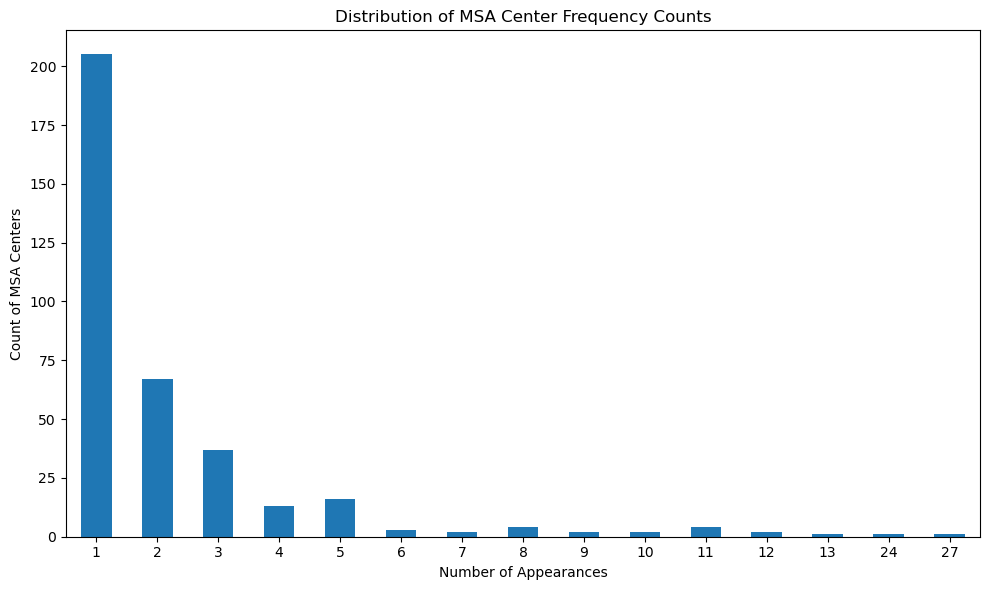

In [84]:
# create a bar plot
plt.figure(figsize=(10, 6))
count_distribution.plot(kind='bar')
plt.title('Distribution of MSA Center Frequency Counts')
plt.xlabel('Number of Appearances')
plt.ylabel('Count of MSA Centers')
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

In [49]:
exploded_polycentric['ln_tot_pop'] = np.log(exploded_polycentric['tot_pop'])

## First Method: Std method

In [52]:
exploded_polycentric['rank'] = exploded_polycentric.groupby('NAMELSAD')['tot_pop'].rank(ascending=False, method='first')

def calculate_sd_metrics(group):
    tot_pop = group['tot_pop']
    max_pop = tot_pop.max()
    hypothetical_sd = np.std([max_pop, 0])
    
    result = {}
    
    # 1.1 Calculate the standard deviation of all tot_pop in the group
    sd_all = np.std(tot_pop)
    result['std_dev_all'] = 1 - (sd_all / hypothetical_sd)
    
    # 1.2 Calculate the standard deviation of the top 2 to top 15 rankings separately
    for i in range(2, 16):
        if len(tot_pop) >= i:
            sd_top_i = np.std(tot_pop.nlargest(i))
            result[f'std_dev_{i}'] = 1 - (sd_top_i / hypothetical_sd)
        else:
            result[f'std_dev_{i}'] = np.nan
    
    # Calculate the mean of the standard deviations for rankings 2, 3, and 4
    ranks_2_to_4 = [result.get(f'std_dev_{i}', np.nan) for i in range(2, 5)]
    ## calculate the average only if when all values of 'std_dev_2','std_dev_3','std_dev_4' are not NaN
    if all(not np.isnan(value) for value in ranks_2_to_4):
        result['avg_std_dev_2_to_4'] = np.mean(ranks_2_to_4)
    else:
        result['avg_std_dev_2_to_4'] = np.nan
    
    return pd.Series(result)

In [54]:
# Apply the function to each group
sd_metrics = exploded_polycentric.groupby('NAMELSAD').apply(calculate_sd_metrics).reset_index()

In [65]:
sd_metrics.describe()

,std_dev_all,std_dev_2,std_dev_3,std_dev_4,std_dev_5,std_dev_6,std_dev_7,std_dev_8,std_dev_9,std_dev_10,std_dev_11,std_dev_12,std_dev_13,std_dev_14,std_dev_15,avg_std_dev_2_to_4
count,360.00,155.00,88.00,51.00,38.00,22.00,19.00,17.00,13.00,11.00,9.00,5.00,3.00,2.00,2.00,51.00
mean,0.68,0.34,0.30,0.30,0.31,0.35,0.36,0.38,0.38,0.39,0.40,0.43,0.45,0.47,0.49,0.37
std,0.39,0.27,0.18,0.13,0.08,0.06,0.05,0.04,0.04,0.05,0.05,0.03,0.04,0.05,0.04,0.17
min,0.02,0.02,0.07,0.13,0.16,0.26,0.29,0.29,0.29,0.29,0.29,0.41,0.43,0.44,0.46,0.08
25%,0.27,0.10,0.18,0.22,0.27,0.31,0.34,0.37,0.37,0.38,0.39,0.42,0.43,0.46,0.47,0.25
50%,1.00,0.29,0.25,0.29,0.30,0.32,0.36,0.37,0.39,0.40,0.41,0.42,0.43,0.47,0.49,0.36
75%,1.00,0.51,0.37,0.36,0.36,0.37,0.39,0.39,0.40,0.42,0.43,0.44,0.47,0.49,0.50,0.47
max,1.00,0.98,0.80,0.73,0.53,0.51,0.48,0.44,0.44,0.46,0.47,0.48,0.50,0.51,0.52,0.77


In [66]:
sd_metrics['std_dev_all'] = sd_metrics['std_dev_all'].apply(lambda x: 0 if x == 1 else x)

In [67]:
sd_metrics

,NAMELSAD,std_dev_all,std_dev_2,std_dev_3,std_dev_4,std_dev_5,std_dev_6,std_dev_7,std_dev_8,std_dev_9,std_dev_10,std_dev_11,std_dev_12,std_dev_13,std_dev_14,std_dev_15,avg_std_dev_2_to_4
0,"Abilene, TX Metro Area",0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Akron, OH Metro Area",0.27,0.67,0.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Albany, GA Metro Area",0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Albany-Lebanon, OR Metro Area",0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Albany-Schenectady-Troy, NY Metro Area",0.27,0.46,0.26,0.26,0.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,"Yakima, WA Metro Area",0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356,"York-Hanover, PA Metro Area",0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
357,"Youngstown-Warren-Boardman, OH-PA Metro Area",0.42,0.23,0.25,0.30,0.33,0.37,0.40,0.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.26
358,"Yuba City, CA Metro Area",0.23,0.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


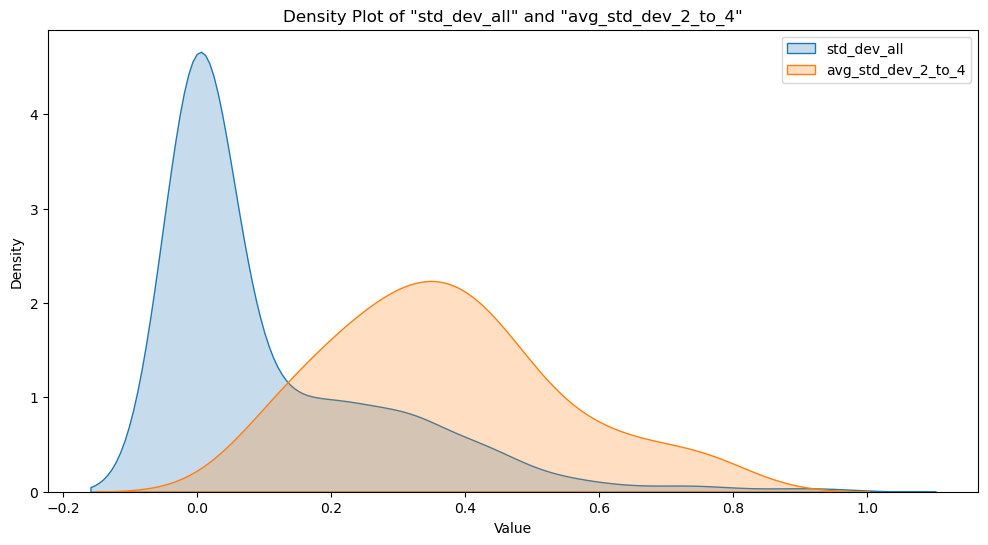

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 、setting the size of the figure
plt.figure(figsize=(12, 6))

# drawing the density figure of the std_dev_all
sns.kdeplot(sd_metrics['std_dev_all'], label='std_dev_all', fill=True)

# drawing the density figure of the avg_std_dev_2_to_4
sns.kdeplot(sd_metrics['avg_std_dev_2_to_4'].dropna(), label='avg_std_dev_2_to_4', fill=True)

plt.title('Density Plot of "std_dev_all" and "avg_std_dev_2_to_4"')
plt.xlabel('Value')
plt.ylabel('Density')

plt.legend()

plt.show()

In [69]:
# sd_metrics.to_csv('sd_metrics.csv', index=False)

## Second Method: Slep-wise ploymetric method

## Third Method: Rank-size distribution method

In [57]:
import statsmodels.api as sm

In [58]:
exploded_polycentric['rank'] = exploded_polycentric.groupby('NAMELSAD')['ln_tot_pop'].rank(ascending=False, method='first')

def calculate_rank_size_beta(group):
    result = {}
    
    # 1.1 Run OLS model in the whole group
    if len(group) > 1:  # determine if the group has more than one observation
        X = sm.add_constant(group['ln_tot_pop'])  # add a constant term
        model = sm.OLS(group['rank'], X).fit()
        result['beta_all'] = model.params[1]
    else:
        result['beta_all'] = np.nan
    
    # 1.2 Run OLS model of the top 2 to top 15 rankings separately
    for i in range(2, 16):
        if len(group) >= i:
            top_i = group.nlargest(i, 'ln_tot_pop')
            X_top_i = sm.add_constant(top_i['ln_tot_pop'])  
            model_top_i = sm.OLS(top_i['rank'], X_top_i).fit()
            result[f'beta_top_{i}'] = model_top_i.params[1]
        else:
            result[f'beta_top_{i}'] = np.nan
    
    # # Calculate the mean of the beta value for rankings 2, 3, and 4
    betas_2_to_4 = [result.get(f'beta_top_{i}', np.nan) for i in range(2, 5)]
    
    # ## calculate the average only if when all values of 'betas_2_','betas_3','betas_4' are not NaN
    if all(not np.isnan(value) for value in betas_2_to_4):
        result['avg_beta_2_to_4'] = np.mean(betas_2_to_4)
    else:
        result['avg_beta_2_to_4'] = np.nan
    
    return pd.Series(result)

In [59]:
# # Apply the function to each group
beta_metrics = exploded_polycentric.groupby('NAMELSAD').apply(calculate_rank_size_beta).reset_index()

In [60]:
beta_metrics

,NAMELSAD,beta_all,beta_top_2,beta_top_3,beta_top_4,beta_top_5,beta_top_6,beta_top_7,beta_top_8,beta_top_9,beta_top_10,beta_top_11,beta_top_12,beta_top_13,beta_top_14,beta_top_15,avg_beta_2_to_4
0,"Abilene, TX Metro Area",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Akron, OH Metro Area",-0.81,-2.48,-0.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Albany, GA Metro Area",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Albany-Lebanon, OR Metro Area",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Albany-Schenectady-Troy, NY Metro Area",-1.00,-1.29,-0.85,-1.05,-1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,"Yakima, WA Metro Area",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356,"York-Hanover, PA Metro Area",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
357,"Youngstown-Warren-Boardman, OH-PA Metro Area",-2.59,-0.68,-1.00,-1.33,-1.67,-2.01,-2.36,-2.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.00
358,"Yuba City, CA Metro Area",-0.69,-0.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
beta_metrics['beta_all'].describe()

count   155.00
mean     -1.22
std       1.65
min     -17.17
25%      -1.34
50%      -0.83
75%      -0.47
max      -0.24
Name: beta_all, dtype: float64

In [62]:
# beta_metrics.to_csv('beta_metrics.csv', index=False)